In [1]:
from pydantic import BaseModel, Field

class Memory(BaseModel):
    content: str = Field(description="The main content of the memory. For example: User expressed interest in learning about French.")

class MemoryCollection(BaseModel):
    memories: list[Memory] = Field(description="A list of memories about the user.")

In [2]:
from langchain_core.messages import HumanMessage

from langchain.chat_models import init_chat_model

model = init_chat_model(
    "anthropic.claude-3-5-sonnet-20241022-v2:0",
    model_provider="bedrock_converse",
)

# Bind schema to model
model_with_structure = model.with_structured_output(MemoryCollection)

# Invoke the model to produce structured output that matches the schema
memory_collection = model_with_structure.invoke([HumanMessage("My name is Lance. I like to bike.")])
memory_collection.memories

[Memory(content="User's name is Lance."),
 Memory(content='Lance enjoys biking as a hobby/activity.')]

In [3]:
memory_collection.memories[0].model_dump()

{'content': "User's name is Lance."}

In [4]:
import uuid
from langgraph.store.memory import InMemoryStore

# Initialize the in-memory store
in_memory_store = InMemoryStore()

# Namespace for the memory to save
user_id = "1"
namespace_for_memory = (user_id, "memories")

# Save a memory to namespace as key and value
key = str(uuid.uuid4())
value = memory_collection.memories[0].model_dump()
in_memory_store.put(namespace_for_memory, key, value)

key = str(uuid.uuid4())
value = memory_collection.memories[1].model_dump()
in_memory_store.put(namespace_for_memory, key, value)

In [5]:
# Search 
for m in in_memory_store.search(namespace_for_memory):
    print(m.dict())

{'namespace': ['1', 'memories'], 'key': '0dceb1a7-e9f3-4b32-ba88-ba18207c2ba3', 'value': {'content': "User's name is Lance."}, 'created_at': '2025-08-12T22:13:43.868187+00:00', 'updated_at': '2025-08-12T22:13:43.868191+00:00', 'score': None}
{'namespace': ['1', 'memories'], 'key': '1e6bd80c-b19a-4109-99f6-5855c234d509', 'value': {'content': 'Lance enjoys biking as a hobby/activity.'}, 'created_at': '2025-08-12T22:13:43.868360+00:00', 'updated_at': '2025-08-12T22:13:43.868362+00:00', 'score': None}


In [6]:
from trustcall import create_extractor

# Create the extractor
trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    tool_choice="Memory",
    enable_inserts=True,
)

In [7]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

# Instruction
instruction = """Extract memories from the following conversation:"""

# Conversation
conversation = [HumanMessage(content="Hi, I'm Lance."), 
                AIMessage(content="Nice to meet you, Lance."), 
                HumanMessage(content="This morning I had a nice bike ride in San Francisco.")]

# Invoke the extractor
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=instruction)] + conversation})

In [8]:
# Messages contain the tool calls
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================

[{'type': 'tool_use', 'name': 'Memory', 'input': {'content': 'Lance went on a bike ride in San Francisco in the morning.'}, 'id': 'tooluse_tXr_rqrtTX-IJyz3Or2WpQ'}]
Tool Calls:
  Memory (tooluse_tXr_rqrtTX-IJyz3Or2WpQ)
 Call ID: tooluse_tXr_rqrtTX-IJyz3Or2WpQ
  Args:
    content: Lance went on a bike ride in San Francisco in the morning.


In [9]:
# Responses contain the memories that adhere to the schema
for m in result["responses"]: 
    print(m)

content='Lance went on a bike ride in San Francisco in the morning.'


In [10]:
# Metadata contains the tool call  
for m in result["response_metadata"]: 
    print(m)

{'id': 'tooluse_tXr_rqrtTX-IJyz3Or2WpQ'}


In [11]:
# Update the conversation
updated_conversation = [AIMessage(content="That's great, did you do after?"), 
                        HumanMessage(content="I went to Tartine and ate a croissant."),                        
                        AIMessage(content="What else is on your mind?"),
                        HumanMessage(content="I was thinking about my Japan, and going back this winter!"),]

# Update the instruction
system_msg = """Update existing memories and create new ones based on the following conversation:"""

# We'll save existing memories, giving them an ID, key (tool name), and value
tool_name = "Memory"
existing_memories = [(str(i), tool_name, memory.model_dump()) for i, memory in enumerate(result["responses"])] if result["responses"] else None
existing_memories

[('0',
  'Memory',
  {'content': 'Lance went on a bike ride in San Francisco in the morning.'})]

In [12]:
# Invoke the extractor with our updated conversation and existing memories
result = trustcall_extractor.invoke({"messages": updated_conversation, 
                                     "existing": existing_memories})

In [13]:
# Messages from the model indicate two tool calls were made
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================

[{'type': 'tool_use', 'name': 'Memory', 'input': {'content': 'Lance went to Tartine and ate a croissant after his bike ride.'}, 'id': 'tooluse_EBIMIho5RWagfyMhjBsLmQ'}, {'type': 'tool_use', 'name': 'Memory', 'input': {'content': 'Lance expressed interest in returning to Japan this winter.'}, 'id': 'tooluse_e5HyfpEVR1ev-Uk4kMqh1w'}, {'type': 'tool_use', 'name': 'PatchDoc', 'input': {'json_doc_id': '0', 'planned_edits': "Need to update the existing memory about Lance's bike ride to include the additional detail about going to Tartine and eating a croissant afterward.", 'patches': [{'op': 'replace', 'path': '/content', 'value': 'Lance went on a bike ride in San Francisco in the morning and then went to Tartine to eat a croissant.'}]}, 'id': 'tooluse_5-vObQb5Q7GtZhD4pMlVYQ'}]
Tool Calls:
  Memory (tooluse_EBIMIho5RWagfyMhjBsLmQ)
 Call ID: tooluse_EBIMIho5RWagfyMhjBsLmQ
  Args:
    content: Lance went to Tarti

In [14]:
# Metadata contains the tool call  
for m in result["response_metadata"]: 
    print(m)

{'id': 'tooluse_EBIMIho5RWagfyMhjBsLmQ'}
{'id': 'tooluse_e5HyfpEVR1ev-Uk4kMqh1w'}
{'id': 'tooluse_5-vObQb5Q7GtZhD4pMlVYQ', 'json_doc_id': '0'}


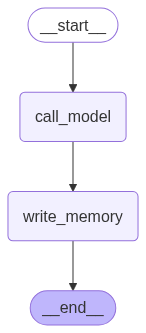

In [15]:
from IPython.display import Image, display

import uuid

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.memory import InMemoryStore
from langchain_core.messages import merge_message_runs
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore

from langchain.chat_models import init_chat_model

model = init_chat_model(
    "anthropic.claude-3-5-sonnet-20241022-v2:0",
    model_provider="bedrock_converse",
)


# Memory schema
class Memory(BaseModel):
    content: str = Field(description="The main content of the memory. For example: User expressed interest in learning about French.")

# Create the Trustcall extractor
trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    tool_choice="Memory",
    # This allows the extractor to insert new memories
    enable_inserts=True,
)

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful chatbot. You are designed to be a companion to a user. 

You have a long term memory which keeps track of information you learn about the user over time.

Current Memory (may include updated memories from this conversation): 

{memory}"""

# Trustcall instruction
TRUSTCALL_INSTRUCTION = """Reflect on following interaction. 

Use the provided tools to retain any necessary memories about the user. 

Use parallel tool calling to handle updates and insertions simultaneously:"""

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memories from the store and use them to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memories", user_id)
    memories = store.search(namespace)

    # Format the memories for the system prompt
    info = "\n".join(f"- {mem.value['content']}" for mem in memories)
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=info)

    # Respond using memory as well as the chat history
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("memories", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "Memory"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    # Merge the chat history and the instruction
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION)] + state["messages"]))

    # Invoke the extractor
    result = trustcall_extractor.invoke({"messages": updated_messages, 
                                        "existing": existing_memories})

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )

# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [16]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Lance")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Lance
================================== Ai Message ==================================

Hi Lance! It's nice to meet you. I'm a friendly AI companion and I'd be happy to chat with you and get to know you better. I'll remember your name is Lance. Is there anything in particular you'd like to talk about?


In [17]:
# User input 
input_messages = [HumanMessage(content="I like to bike around San Francisco")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to bike around San Francisco
================================== Ai Message ==================================

That's great to know, Lance! San Francisco is quite a city for cycling, though those hills can be quite a challenge! I'll remember that you enjoy biking in SF.

Would you like to share more about your cycling experiences? For instance, do you have any favorite routes or neighborhoods you particularly enjoy riding through? Also, do you bike for exercise, commuting, or both? I'd love to learn more about your biking adventures in the city.


In [18]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memories", user_id)
memories = across_thread_memory.search(namespace)
for m in memories:
    print(m.dict())

{'namespace': ['memories', '1'], 'key': '05cb08bd-7f08-410c-9447-41b0dd2420e4', 'value': {'content': "User's name is Lance."}, 'created_at': '2025-08-12T22:14:51.788727+00:00', 'updated_at': '2025-08-12T22:14:51.788728+00:00', 'score': None}
{'namespace': ['memories', '1'], 'key': 'e08f3173-4662-44ce-826b-47ad724d7d18', 'value': {'content': 'User enjoys biking around San Francisco.'}, 'created_at': '2025-08-12T22:15:01.230626+00:00', 'updated_at': '2025-08-12T22:15:01.230627+00:00', 'score': None}


In [19]:
# User input 
input_messages = [HumanMessage(content="I also enjoy going to bakeries")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I also enjoy going to bakeries
================================== Ai Message ==================================

I'll make a note that you enjoy going to bakeries! That's a great interest to have, especially in San Francisco which has so many wonderful bakeries. This pairs nicely with your cycling hobby too - you can bike to different bakeries around the city and burn off some of those delicious calories!

Since you enjoy both biking and bakeries, do you have any favorite bakery spots in SF that you like to cycle to? Places like Tartine in the Mission or b. patisserie in Pacific Heights are pretty popular destinations. I'd love to hear about your favorites!


In [20]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="What bakeries do you recommend for me?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What bakeries do you recommend for me?
================================== Ai Message ==================================

Since I know you're in San Francisco and enjoy visiting bakeries, I'd be happy to recommend some great local spots! Here are some of San Francisco's most beloved bakeries:

1. Tartine Bakery (Mission District) - Famous for their country bread and morning buns
2. B. Patisserie (Pacific Heights) - Known for amazing kouign-amann and French pastries
3. Arsicault Bakery (Richmond/Hayes Valley) - Named "Best Croissant in America" by Bon Appétit
4. Mr. Holmes Bakehouse (Multiple locations) - Home of the "Cruffin" and creative pastries
5. Acme Bread Company (Ferry Building) - Excellent artisanal breads

Since you enjoy biking, you could actually make a nice bike tour out of visiting these spots! The ride between these bakeries would give you a great tour of different San Francisco neighborhoods